In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
'''
데이터 구성 함수 정의
'''
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [4]:
# load dataset
dataset = read_csv('./data/pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction : 풍향을 숫자로 표현(0 and n_classes-1)
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_steps = 12
n_features = 8 # 각 step 마다 몇 개의 feature로 구성되어 있는지

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
print(reframed.shape)

(43788, 104)


In [5]:
reframed

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var1(t-11),var2(t-11),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
12,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.0,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.0,0.0
13,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.0,0.0,0.164990,0.470588,0.229508,0.618183,0.666667,0.046586,0.0,0.0
14,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.0,0.0,0.158954,0.455882,0.229508,0.618183,0.666667,0.053456,0.0,0.0
15,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.0,0.0,0.154930,0.455882,0.229508,0.618183,0.666667,0.060326,0.0,0.0
16,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.0,0.0,0.159960,0.455882,0.229508,0.636364,0.666667,0.063385,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.008048,0.264706,0.229508,0.781818,0.333333,0.243664,0.000000,0.0,0.008048,0.264706,...,0.0,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0
43796,0.008048,0.264706,0.229508,0.781818,0.333333,0.255883,0.000000,0.0,0.008048,0.264706,...,0.0,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0
43797,0.008048,0.264706,0.262295,0.781818,0.333333,0.265812,0.000000,0.0,0.007042,0.264706,...,0.0,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.0,0.0
43798,0.007042,0.264706,0.278689,0.781818,0.333333,0.278031,0.000000,0.0,0.012072,0.264706,...,0.0,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.0,0.0


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = (365 * 24) * 3
n_validate_hours = (365 * 24) * 4
train = values[:n_train_hours, :]
validate = values[n_train_hours:n_validate_hours, :]
test = values[n_validate_hours:, :]

# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
validate_X, validate_y = validate[:, :n_obs], validate[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print('[ Train Data ]', 'length', len(train_X), 'X_shape :', train_X.shape, 'y_shape :', train_y.shape)
print('[ Validate Data ]', 'length', len(validate_X), 'X_shape :', validate_X.shape, 'y_shape :', validate_y.shape)
print('[ Test Data ]', 'length', len(test_X), 'X_shape :', test_X.shape, 'y_shape :', test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
validate_X = validate_X.reshape((validate_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print('[ Reshape Train Data ]', 'X_shape :', train_X.shape, 'y_shape :', train_y.shape)
print('[ Reshape Validate Data ]', 'X_shape :', validate_X.shape, 'y_shape :', validate_y.shape)
print('[ Reshape Test Data ]', 'X_shape :', test_X.shape, 'y_shape :', test_y.shape)

[ Train Data ] length 26280 X_shape : (26280, 96) y_shape : (26280,)
[ Validate Data ] length 8760 X_shape : (8760, 96) y_shape : (8760,)
[ Test Data ] length 8748 X_shape : (8748, 96) y_shape : (8748,)
[ Reshape Train Data ] X_shape : (26280, 12, 8) y_shape : (26280,)
[ Reshape Validate Data ] X_shape : (8760, 12, 8) y_shape : (8760,)
[ Reshape Test Data ] X_shape : (8748, 12, 8) y_shape : (8748,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(70, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [9]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(validate_X, validate_y), verbose=1, shuffle=True)

Epoch 1/100
365/365 [==============================] - 4s 11ms/step - loss: 0.0296 - val_loss: 0.0229
Epoch 2/100
365/365 [==============================] - 4s 10ms/step - loss: 0.0185 - val_loss: 0.0193
Epoch 3/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 4/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0136 - val_loss: 0.0173
Epoch 5/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 7/100
365/365 [==============================] - 3s 10ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 8/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 9/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 10/100
365/365 [==============================] - 3s 9ms/step - loss: 0.0134 - val

365/365 [==============================] - 3s 8ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 82/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0124 - val_loss: 0.0133
Epoch 83/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 84/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0134
Epoch 85/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 86/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 87/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0135
Epoch 88/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0134
Epoch 89/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 90/100
365/365 [==============================] - 3s 8ms/step - loss: 0.0123 - val_loss: 

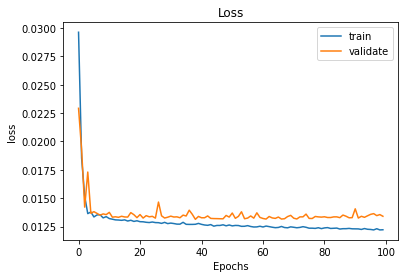

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.title('Loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()

In [11]:
# make a prediction
yhat = model.predict(validate_X)

reshape_validate_X = validate_X.reshape((validate_X.shape[0], n_steps * n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, reshape_validate_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
validate_y = validate_y.reshape((len(validate_y), 1))
inv_y = concatenate((validate_y, reshape_validate_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 28.094


In [12]:
from sklearn.metrics import r2_score

r2_score_ret = r2_score(inv_y, inv_yhat)
print('R2 Score: %.5f' % r2_score_ret)

R2 Score: 0.91792


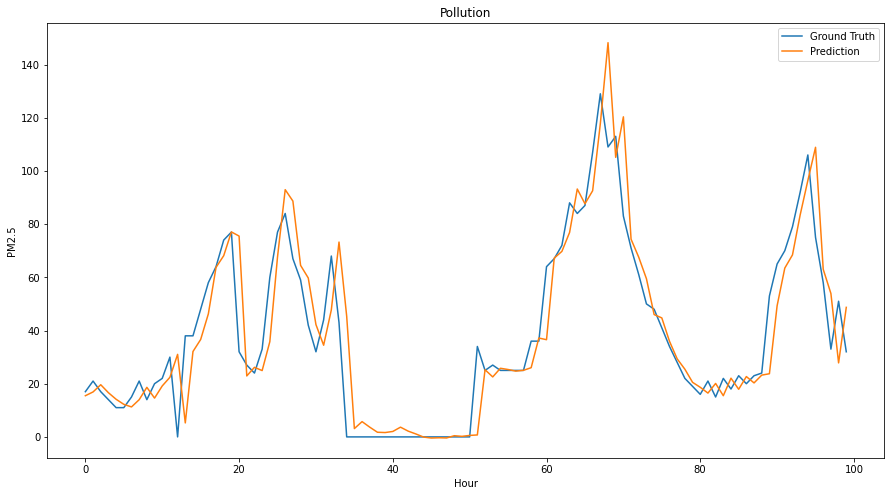

In [13]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(inv_y[-100:], label='Ground Truth')
pyplot.plot(inv_yhat[-100:], label='Prediction')
pyplot.title('Pollution')
pyplot.xlabel('Hour')
pyplot.ylabel('PM2.5')
pyplot.legend()
pyplot.show()

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

RMSE: 28.094


In [15]:
from sklearn.metrics import r2_score

r2_score_ret = r2_score(inv_y, inv_yhat)
print('R2 Score: %.5f' % r2_score_ret)

R2 Score: 0.91792


In [16]:
# make a prediction
yhat = model.predict(test_X)

reshape_test_X = test_X.reshape((test_X.shape[0], n_steps * n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, reshape_test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, reshape_test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 23.270


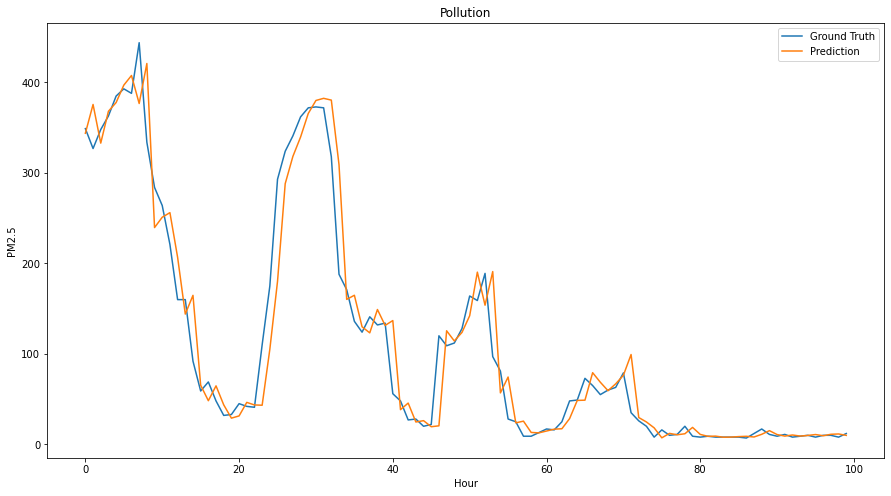

In [17]:
pyplot.figure(figsize=(15, 8))
pyplot.plot(inv_y[-100:], label='Ground Truth')
pyplot.plot(inv_yhat[-100:], label='Prediction')
pyplot.title('Pollution')
pyplot.xlabel('Hour')
pyplot.ylabel('PM2.5')
pyplot.legend()
pyplot.show()

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate forecasts
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

RMSE: 23.270


In [19]:
from sklearn.metrics import r2_score

r2_score_ret = r2_score(inv_y, inv_yhat)
print('R2 Score: %.5f' % r2_score_ret)

R2 Score: 0.93822


In [20]:
dataset.corr()

,pollution,dew,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157585,-0.090798,-0.045544,-0.234362,0.022226,-0.049045
dew,0.157585,1.000000,0.824432,-0.778737,-0.296720,-0.034484,0.125053
temp,-0.090798,0.824432,1.000000,-0.827205,-0.154902,-0.092726,0.049037
press,-0.045544,-0.778737,-0.827205,1.000000,0.185380,0.069031,-0.079840
wnd_spd,-0.234362,-0.296720,-0.154902,0.185380,1.000000,0.021876,-0.010137
snow,0.022226,-0.034484,-0.092726,0.069031,0.021876,1.000000,-0.009553
rain,-0.049045,0.125053,0.049037,-0.079840,-0.010137,-0.009553,1.000000


c:\users\choih\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


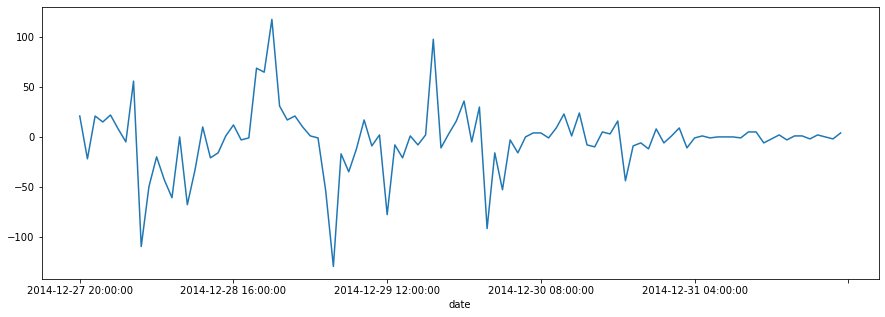

mean -0.002671 std 27.567844 



In [21]:
from numpy import mean, std

# 차분하여 Stationary Data로
diff_1 = dataset['pollution'].diff(periods=1).iloc[1:]

diff_1[-100:].plot(figsize=(15,5))
pyplot.show()
print('mean %f' % mean(diff_1), 'std %f \n' % std(diff_1))